<a href="https://colab.research.google.com/github/HadiAskari/5G-Waverform-Channel-Impairment-Classification/blob/main/Variable_noise_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LIBRARIES**

In [ ]:
gnv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **DATA LOADING**

In [ ]:
import glob
directory=[]
for name in glob.glob('/content/drive/MyDrive/My Last Hope Data/Variable_noise/0-5/*'): 
    directory.append(name) 
for name in glob.glob('/content/drive/MyDrive/My Last Hope Data/Variable_noise/5-10/*'): 
    directory.append(name) 
for name in glob.glob('/content/drive/MyDrive/My Last Hope Data/Variable_noise/10-15/*'): 
    directory.append(name) 
for name in glob.glob('/content/drive/MyDrive/My Last Hope Data/Variable_noise/15-20/*'): 
    directory.append(name) 
for name in glob.glob('/content/drive/MyDrive/My Last Hope Data/Variable_noise/20-25/*'): 
    directory.append(name) 
for name in glob.glob('/content/drive/MyDrive/My Last Hope Data/Variable_noise/25-30/*'): 
    directory.append(name) 


In [ ]:
len(directory)

30

In [ ]:
master_data=[]
for i in range(len(directory)):
  targets=directory[i] 
  target_pss=np.loadtxt(targets, delimiter=",")
  target_pss=transpose(target_pss)
  target_pss=np.asarray(target_pss)
  master_data.append(target_pss)


In [ ]:
x=master_data[15]
x.shape

(2, 54800)

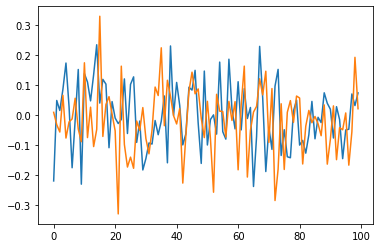

In [ ]:
plt.plot(x.transpose()[:100, :])

In [ ]:
master_data_2=[]
master_labels=np.zeros(shape=(3000,6))
master1=np.zeros(shape=(3000,2,548))
list_label=["0-5","6-10","11-15","16-20","21-25","26-30"]
print("Labels: ",list_label)

Labels:  ['0-5', '6-10', '11-15', '16-20', '21-25', '26-30']


In [ ]:
for j in range(30):
  for i in range(100):
    s=(100*j)+i
    master1[s,:,:]=master_data[j][:,(i*548):(548+(i*548))]

In [ ]:
final_data=master1
final_data.shape

(3000, 2, 548)

In [ ]:
if (final_data[2999,0,:] == final_data[2998,1,:]).all():
  print('haha')
else:
  print("no haha")

no haha


In [ ]:
for i in range(500):
  master_labels[i,0]=1
  master_labels[i+500,1]=1
  master_labels[i+1000,2]=1
  master_labels[i+1500,3]=1
  master_labels[i+2000,4]=1
  master_labels[i+2500,5]=1

master_labels.shape

(3000, 6)

In [ ]:
master_labels

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [ ]:
a=final_data
b=master_labels

In [ ]:
from mlxtend.preprocessing import shuffle_arrays_unison
X,Y=shuffle_arrays_unison(arrays=[a, b], random_seed=3)

In [ ]:
X_train=X[0:2500,:,:]
X_test=X[2500:,:,:]
Y_train=Y[0:2500,:]
Y_test=Y[2500:,:]

In [ ]:
print("Sample no: 5")
print("Data:\n",X[5])
print("Label: ",Y[5])

Sample no: 5
Data:
 [[ 0.35227214 -0.46063048 -0.48557888 ...  0.40605917 -0.74855307
  -0.20563198]
 [-0.29481857  1.36053869 -1.28138544 ... -1.25323492 -0.21478347
  -0.04694557]]
Label:  [1. 0. 0. 0. 0. 0.]


In [ ]:
in_shape = final_data[0].shape
out_shape = tuple([1]) + in_shape
print(in_shape)
print(out_shape)

(2, 548)
(1, 2, 548)


# **CONVOLUTION NEURAL NETWORK**

In [ ]:
dr = 0.5
model = Sequential()
model.add(Reshape(out_shape, input_shape = in_shape))
model.add(ZeroPadding2D((0, 2), data_format = 'channels_first'))
model.add(Conv2D(256, (1, 3), padding = 'valid', activation = "relu", name="conv1", kernel_initializer='glorot_uniform', data_format="channels_first"))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0,2), data_format = 'channels_first'))
model.add(Conv2D(80, (2, 3), activation="relu", name="conv3", padding="valid", kernel_initializer="glorot_uniform", data_format="channels_first"))
model.add(Dropout(dr))
model.add(Flatten())   
model.add(Dense(256, activation="relu", name="dense1", kernel_initializer="he_normal",))
model.add(Dropout(dr))
model.add(Dense(6, name="dense3", kernel_initializer="he_normal", activation = 'softmax'))
model.add(Reshape([len(list_label)]))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 2, 548)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 1, 2, 552)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 2, 550)       1024      
_________________________________________________________________
dropout (Dropout)            (None, 256, 2, 550)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 256, 2, 554)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 80, 1, 552)        122960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 80, 1, 552)        0

In [ ]:
%load_ext tensorboard
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
model.fit(X_train, Y_train, epochs = 100, batch_size = 64, validation_data=(X_test,Y_test), callbacks=[tensorboard_callback])

Epoch 1/100
40/40 [==============================] - 46s 68ms/step - loss: 1.4753 - accuracy: 0.2987 - val_loss: 0.7319 - val_accuracy: 0.6080
Epoch 2/100
40/40 [==============================] - 1s 30ms/step - loss: 0.7032 - accuracy: 0.6792 - val_loss: 0.5559 - val_accuracy: 0.6940
Epoch 3/100
40/40 [==============================] - 1s 30ms/step - loss: 0.4420 - accuracy: 0.8066 - val_loss: 0.2786 - val_accuracy: 0.9140
Epoch 4/100
40/40 [==============================] - 1s 32ms/step - loss: 0.3195 - accuracy: 0.8856 - val_loss: 0.4444 - val_accuracy: 0.8520
Epoch 5/100
40/40 [==============================] - 1s 30ms/step - loss: 0.3009 - accuracy: 0.8804 - val_loss: 0.1482 - val_accuracy: 0.9540
Epoch 6/100
40/40 [==============================] - 1s 30ms/step - loss: 0.2045 - accuracy: 0.9239 - val_loss: 0.3492 - val_accuracy: 0.8280
Epoch 7/100
40/40 [==============================] - 1s 30ms/step - loss: 0.2367 - accuracy: 0.9006 - val_loss: 0.1316 - val_accuracy: 0.9500
Epoch

In [ ]:
model_2 = Sequential()
model_2.add(Reshape(out_shape, input_shape = in_shape))
model_2.add(ZeroPadding2D((2, 2), data_format = 'channels_first'))
model_2.add(ZeroPadding2D(padding=(1, 1)))
model_2.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.01)))
model_2.add(ZeroPadding2D(padding=(1, 1)))
model_2.add(Conv2D(128, kernel_size=(2,2), activation='relu', strides=(1, 1), padding='valid'))
model_2.add(ZeroPadding2D(padding=(1, 1)))
model_2.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.01)))
model_2.add(ZeroPadding2D(padding=(1, 1)))
model_2.add(Conv2D(256, kernel_size=(2,2), activation='relu', strides=(1, 1), padding='valid'))
model_2.add(ZeroPadding2D(padding=(1, 1)))
model_2.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02)))
model_2.add(ZeroPadding2D(padding=(1, 1)))
model_2.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02)))
model_2.add(ZeroPadding2D(padding=(1, 1)))
model_2.add(Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1, 1)))
model_2.add(ZeroPadding2D(padding=(1, 1)))
model_2.add(Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1, 1)))
model_2.add(ZeroPadding2D(padding=(1, 1)))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(ZeroPadding2D(padding=(1, 1)))
model_2.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02)))
model_2.add(ZeroPadding2D(padding=(1, 1)))
model_2.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02)))
model_2.add(ZeroPadding2D(padding=(1, 1)))
model_2.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.05)))
model_2.add(ZeroPadding2D(padding=(1, 1)))
model_2.add(Conv2D(128, kernel_size=(2,2), activation='relu', strides=(1, 1), padding='valid'))
model_2.add(Flatten())  
model_2.add(Dense(256, activation="relu", name="dense1", kernel_initializer="he_normal",))
model_2.add(Dropout(0.3))
model_2.add(Dense(128, activation="relu", name="dense2", kernel_initializer="he_normal",))
model_2.add(Dropout(0.2))
model_2.add(Dense(64, activation="relu", name="dense3", kernel_initializer="he_normal",))
model_2.add(Dropout(0.2))
model_2.add(Dense(32, activation="relu", name="dense4", kernel_initializer="he_normal",))
model_2.add(Dropout(0.2))
model_2.add(Dense(6, activation='softmax'))
model_2.add(Reshape([len(list_label)]))

NameError: ignored

In [ ]:
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model_2.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 2, 548)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 1, 6, 552)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 8, 552)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 6, 128)         636032    
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 3, 8, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 7, 128)         65664     
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 4, 9, 128)         0

In [ ]:
%load_ext tensorboard
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
model_2.fit(X_train, Y_train, epochs = 100, batch_size = 64, validation_data=(X_test,Y_test), callbacks=[tensorboard_callback])

Epoch 1/100
40/40 [==============================] - 6s 61ms/step - loss: 10.2410 - accuracy: 0.1794 - val_loss: 2.6348 - val_accuracy: 0.1540
Epoch 2/100
40/40 [==============================] - 0s 11ms/step - loss: 2.2666 - accuracy: 0.1539 - val_loss: 1.8237 - val_accuracy: 0.1960
Epoch 3/100
40/40 [==============================] - 0s 11ms/step - loss: 1.8099 - accuracy: 0.1486 - val_loss: 1.7949 - val_accuracy: 0.1540
Epoch 4/100
40/40 [==============================] - 0s 10ms/step - loss: 1.7923 - accuracy: 0.1621 - val_loss: 1.7927 - val_accuracy: 0.1460
Epoch 5/100
40/40 [==============================] - 0s 10ms/step - loss: 1.7916 - accuracy: 0.1768 - val_loss: 1.7938 - val_accuracy: 0.1460
Epoch 6/100
40/40 [==============================] - 0s 11ms/step - loss: 1.7915 - accuracy: 0.1831 - val_loss: 1.7940 - val_accuracy: 0.1460
Epoch 7/100
40/40 [==============================] - 0s 11ms/step - loss: 1.7921 - accuracy: 0.1704 - val_loss: 1.7944 - val_accuracy: 0.1460
Epoch

In [ ]:
 X_test[45], Y_test[45]

In [ ]:
model_2.predict(np.expand_dims(X_test[45], axis=0))

In [ ]:
plt.plot(X_train[0].transpose())
print(Y_train[0])

In [ ]:
for i in range(1, 100):
  if Y_train[i].tolist() == [0, 0, 1, 0, 0, 0]:
    break
plt.plot(X_train[i].transpose())
print(Y_train[i])
print(i)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

In [ ]:
print(Y_train)
y_pred_2 = model_2.predict(X_test)
y_pred_2 = (y_pred_2 > 0.5) 

# **RESULTS**

In [ ]:
mycm_2 = confusion_matrix(Y_test.argmax(axis=1), y_pred_2.argmax(axis=1))
print(mycm_2)

[[91  0  0  0  0  0]
 [15 58  0  0  0  0]
 [ 0 14 63  0  0  0]
 [ 0  0  8 89  1  0]
 [ 0  0  0  7 74  3]
 [ 0  0  0  0  1 76]]


In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

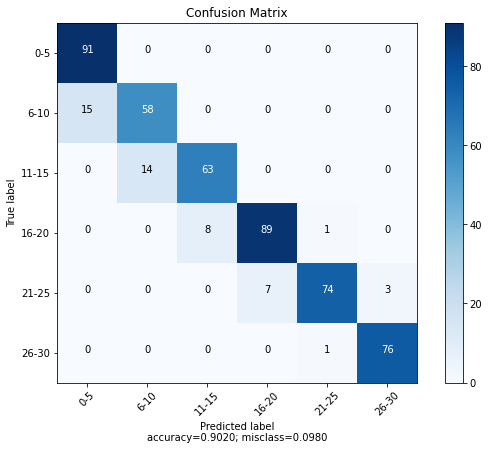

In [ ]:
plot_confusion_matrix(cm           = mycm_2, 
                      normalize    = False,
                      target_names = ['0-5', '6-10', '11-15', '16-20', '21-25', '26-30'],
                      title        = "Confusion Matrix")

# **OTHER ML MODELS**

In [ ]:
# reaign the data in the right formate 

my_labels=np.zeros((3000,1))
for i in range(3000):
  if Y[i,0]==1:
    my_labels[i]=1
  elif Y[i,1]==1:
    my_labels[i]=2
  elif Y[i,2]==1:
    my_labels[i]=3
  elif Y[i,3]==1:
    my_labels[i]=4
  elif Y[i,4]==1:
    my_labels[i]=5
  else:
    my_labels[i]=6

In [ ]:
#test to see the conversion was correct 
print(my_labels[2440])
print(Y[2440])

[3.]
[0. 0. 1. 0. 0. 0.]


In [ ]:
print(X.shape)
print(my_labels.shape)

(3000, 2, 548)
(3000, 1)


In [ ]:
X[0]

array([[ 0.01090652,  0.13959095, -0.01581117, ..., -0.14624046,
         0.31024878, -0.19946527],
       [ 0.16522877,  0.14345998, -0.08027198, ..., -0.16514072,
         0.04409358, -0.00790446]])

In [ ]:
#convert to complex shape
X_new=np.empty((3000,548), dtype=complex, order='C')

for i in range(3000):
  for j in range(548):
    X_new[i,j]=complex(X[i,0,j],X[i,1,j])

In [ ]:
X_new.shape

(3000, 548)

In [ ]:
#use absolute as random forest doesn't cater real complex values 
X_new_2=np.abs(X_new)

In [ ]:
X_new_2.shape

(3000, 548)

# **Random Forest**

In [ ]:
#train test split for random forest 
from sklearn.model_selection import train_test_split
X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(X_new_2, my_labels, test_size=0.3)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=20)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train_rand,y_train_rand)

y_pred=clf.predict(X_test_rand)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy Random Forest:",metrics.accuracy_score(y_test_rand, y_pred))

Accuracy Random Forest: 0.8822222222222222


# **SVM**

In [ ]:
from sklearn import svm
import pandas as pd


SVM = svm.LinearSVC()
SVM.fit(X_train_rand,y_train_rand)
y_pred_2=SVM.predict(X_test_rand)
round(SVM.score(X_train_rand,y_train_rand), 10)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9147619048

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy SVM:",metrics.accuracy_score(y_test_rand, y_pred_2))

Accuracy SVM: 0.4577777777777778


# **MLP CLASSIFIER**

In [ ]:
from sklearn.neural_network import MLPClassifier

NN = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(5, 2), random_state=1)
NN.fit(X_train_rand,y_train_rand)
y_predict_3=NN.predict(X_test_rand)
round(NN.score(X_train_rand,y_train_rand), 4)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.9871

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy MLP Classifier:",metrics.accuracy_score(y_test_rand, y_predict_3))

Accuracy MLP Classifier: 0.9844444444444445
